# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from entsoe import EntsoePandasClient



# Load client

In [2]:
client = EntsoePandasClient(api_key="7d7d794e-2703-4292-97eb-6ca2b12bd5b8")

In [3]:
start = pd.Timestamp("2025-09-01", tz="Europe/Stockholm")
end   = pd.Timestamp("2025-09-04", tz="Europe/Stockholm")

# Country-level load; for zones, use the bidding-zone identifier (see mappings.py).
df_actual   = client.query_load("SE", start=start, end=end)          # Actual Total Load

<Axes: title={'center': 'Actual Total Load Sweden'}, xlabel='Date', ylabel='Load (MW)'>

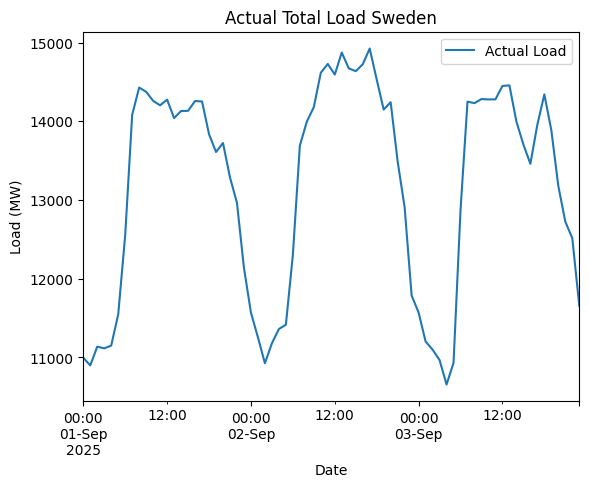

In [4]:
df_actual.plot(title="Actual Total Load Sweden", ylabel="Load (MW)", xlabel="Date")

In [18]:
#!/usr/bin/env python3
import os
from pathlib import Path
import pandas as pd
from entsoe import EntsoePandasClient
import plotly.express as px
import plotly.graph_objects as go


# Optional: load ENTSOE_API_KEY from a local .env (gitignore this file!)
try:
    from dotenv import load_dotenv
    load_dotenv()
except Exception:
    pass


In [ ]:
# ---------------- Settings ----------------
TZ = "Europe/Stockholm"
COUNTRY_CODE = "SE"
DAYS_BACK = 7

SITE_TITLE = "Sweden Load Dashboard"
SITE_TAGLINE = "Interactive charts generated from ENTSO-E data"
OUTPUT_DIR = Path("docs")
OUTPUT_FILE = OUTPUT_DIR / "index.html"

# -------------- Data helpers --------------
def get_time_range(days_back: int):
    now = pd.Timestamp.now(tz=TZ).floor("h")
    start = now - pd.Timedelta(days=days_back)
    end = now
    return start, end

def fetch_load_df(client: EntsoePandasClient, country_code: str,
                  start: pd.Timestamp, end: pd.Timestamp) -> pd.DataFrame:
  
    """Return exactly two columns: Date (tz-aware) and Load (MW)."""
    
    data = client.query_load(country_code, start=start, end=end)

    if isinstance(data, pd.DataFrame):
        df = data.copy()
    else:
        df = data.to_frame()

    # Ensure tz-aware, convert to display TZ, and make Date a column
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")
    df.index = df.index.tz_convert(TZ)
    df = df.rename_axis("Date").reset_index()

    # Rename the (single) value column to Load (MW)
    value_cols = [c for c in df.columns if c != "Date"]
    if not value_cols:
        raise ValueError("No value column returned from ENTSO-E.")
    df.rename(columns={value_cols[0]: "Load (MW)"}, inplace=True)

    # Enforce dtypes and return only the two columns
    df["Date"] = pd.to_datetime(df["Date"])
    df["Load (MW)"] = pd.to_numeric(df["Load (MW)"], errors="coerce")
    return df.sort_values("Date")[["Date", "Load (MW)"]].reset_index(drop=True)

# -------------- Figures -------------------
def make_actual_load_plot(df: pd.DataFrame, title: str):
    fig = px.line(df, x="Date", y="Load (MW)", title=title, template="plotly_white")
    fig.update_layout(
        hovermode="x unified",
        xaxis=dict(
            title=f"Date ({TZ})",
            rangeslider=dict(visible=True),
            rangeselector=dict(
                buttons=[
                    dict(count=24,  label="1d", step="hour", stepmode="backward"),
                    dict(count=72,  label="3d", step="hour", stepmode="backward"),
                    dict(count=168, label="7d", step="hour", stepmode="backward"),
                    dict(step="all", label="All"),
                ]
            ),
        ),
        yaxis=dict(title="Load (MW)"),
        margin=dict(l=60, r=30, t=60, b=40),
    )
    return fig

def make_daily_avg_plot(df: pd.DataFrame, title: str):
    daily = (
        df.assign(day=df["Date"].dt.floor("D"))
          .groupby("day", as_index=False)["Load (MW)"].mean()
          .rename(columns={"day": "Date", "Load (MW)": "Daily Avg (MW)"})
    )
    fig = px.line(daily, x="Date", y="Daily Avg (MW)", title=title, template="plotly_white", markers=True)
    fig.update_layout(
        hovermode="x unified",
        xaxis=dict(title=f"Date ({TZ})"),
        yaxis=dict(title="Daily Average Load (MW)"),
        margin=dict(l=60, r=30, t=60, b=40),
    )
    return fig

def make_daily_avg_bar_plot(df: pd.DataFrame, title: str):
    # Aggregate hourly → daily average
    daily = (
        df.assign(day=df["Date"].dt.floor("D"))
          .groupby("day", as_index=False)["Load (MW)"].mean()
          .rename(columns={"day": "Date", "Load (MW)": "Daily Avg (MW)"})
    )

    fig = px.bar(
        daily,
        x="Date",
        y="Daily Avg (MW)",
        title=title,
        template="plotly_white",
    )
    fig.update_layout(
        hovermode="x unified",
        xaxis=dict(title="Date"),
        yaxis=dict(title="Daily average load (MW)"),
        margin=dict(l=60, r=30, t=60, b=40),
    )
    fig.update_traces(hovertemplate="Date: %{x|%Y-%m-%d}<br>Daily avg: %{y:.0f} MW<extra></extra>")
    return fig



# -------------- Page template -------------
def build_page(fig_sections):
    # NOTE: We DO NOT include a <script src="plotly-latest..."> here.
    # The first figure's HTML will include the correct Plotly JS via include_plotlyjs="cdn".
    sections_html = "\n".join(
        f"""
        <section id="{sec['id']}">
          <h2>{sec['title']}</h2>
          <p class="blurb">{sec['blurb']}</p>
          {sec['fig_html']}
        </section>
        """ for sec in fig_sections
    )

    return f"""<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <title>{SITE_TITLE}</title>
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <meta name="description" content="{SITE_TAGLINE}">
  <style>
    :root {{
      --maxw: 1100px; --pad: 16px; --accent: #0f766e; --text: #1f2937; --muted: #6b7280; --border: #e5e7eb;
    }}
    * {{ box-sizing: border-box; }}
    body {{ margin: 0; color: var(--text); font-family: system-ui, -apple-system, Segoe UI, Roboto, Inter, sans-serif; background: #fafafa; }}
    header {{ background: white; border-bottom: 1px solid var(--border); }}
    .wrap {{ max-width: var(--maxw); margin: 0 auto; padding: 18px var(--pad); }}
    h1 {{ margin: 0 0 6px; font-size: 1.6rem; }}
    .tagline {{ color: var(--muted); margin: 0; }}
    nav {{ margin-top: 10px; display: flex; gap: 12px; flex-wrap: wrap; }}
    nav a {{ text-decoration: none; color: var(--accent); border: 1px solid var(--border); padding: 6px 10px; border-radius: 999px; background: #fff; }}
    main .wrap {{ padding-top: 20px; }}
    section {{ background: white; border: 1px solid var(--border); border-radius: 14px; padding: 14px; margin-bottom: 22px; box-shadow: 0 1px 2px rgba(0,0,0,0.04); }}
    h2 {{ margin: 6px 0 10px; font-size: 1.25rem; }}
    .blurb {{ color: var(--muted); margin-top: 0; }}
    footer {{ color: var(--muted); font-size: 0.9rem; padding: 32px var(--pad); text-align: center; }}
  </style>
</head>
<body>
  <header>
    <div class="wrap">
      <h1>{SITE_TITLE}</h1>
      <p class="tagline">{SITE_TAGLINE}</p>
      <nav>
        <a href="#actual-load">Actual Load</a>
        <a href="#daily-avg">Daily Average</a>
        <a href="#notes">Notes</a>
      </nav>
    </div>
  </header>

  <main>
    <div class="wrap">
      {sections_html}
      <section id="notes">
        <h2>Notes</h2>
        <ul>
          <li>Times are displayed in {TZ}.</li>
          <li>The daily average chart aggregates the hourly values by day.</li>
          <li>Data source: ENTSO-E (Actual Total Load for {COUNTRY_CODE}).</li>
        </ul>
      </section>
    </div>
  </main>

  <footer>
    Built with Python + Plotly, deployed on GitHub Pages.
  </footer>
</body>
</html>"""

# -------------- Main ----------------------
def main():
  
    api_key = os.getenv("ENTSOE_API_KEY")
    
    if not api_key:
      
        raise SystemExit("Missing ENTSOE_API_KEY. Put it in an environment variable or .env file.")

    start, end = get_time_range(DAYS_BACK)
    client = EntsoePandasClient(api_key=api_key)

    df = fetch_load_df(client, COUNTRY_CODE, start, end)
    fig1 = make_actual_load_plot(df, f"Actual Total Load – {COUNTRY_CODE}")
    fig2 = make_daily_avg_bar_plot(df, "Distribution of Daily Average Load")

    fig1_html = fig1.to_html(include_plotlyjs="cdn", full_html=False,
                         config={"displaylogo": False, "responsive": True})
    fig2_html = fig2.to_html(include_plotlyjs=False, full_html=False,
                         config={"displaylogo": False, "responsive": True})

    sections = [
        {
            "id": "actual-load",
            "title": "Actual Total Load",
            "blurb": f"Hourly total load for {COUNTRY_CODE} over the last {DAYS_BACK} days.",
            "fig_html": fig1_html,
        },
        {
            "id": "daily-avg",
            "title": "Daily Average Distribution",
            "blurb": "Histogram of the daily mean load across the selected period.",
            "fig_html": fig2_html,
        },
    ]

    page_html = build_page(sections)
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    OUTPUT_FILE.write_text(page_html, encoding="utf-8")
    print(f"Wrote {OUTPUT_FILE.resolve()}")

if __name__ == "__main__":
  main()


Wrote C:\Users\alber\Desktop\Side_projects\load-forcasting-sweden\docs\index.html
